# IT Academy - Data Science amb Python
## Tasca 7: Estructura de control

###  [Github Registre de Logs](https://github.com/jesussantana/Registre_de_logs)

###  Exercici 1
- Normalitza, identifica i enumera cada un dels atributs / variables de l'estructura de l'arxiu "Web_access_log-akumenius.com" que trobaràs al repositori de GitHub "Data-sources".

In [1]:
import numpy as np
import pandas as pd
import time
import requests
import re
from datetime import datetime
from datetime import timedelta

pd.set_option('display.max_columns', None)

In [2]:
path = '../Data/Web_access_log-akumenius.com.txt'

Logs_raw = pd.read_csv(path, sep='\s | \- | \"', names =['DNS','IP','Location','Date','Time','Request','Status','Size','Referer','UserAgent'], nrows = 1000, engine='python')

Logs_copy = Logs_raw.copy()

Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN
1,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN
2,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN
3,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN
4,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN


###  Exercici 2
- Neteja, preprocesa, estructura i transforma (dataframe) les dades del registre d'Accés a la web.

In [3]:
Logs_copy.tail()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
995,www.akumenius.com 66.249.76.216,- [23/Feb/2014:03:34:53 +0100],GET /destinos-baratos/destinosEstrelles/hotele...,"-""",Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,NaN,NaN,NaN,NaN,NaN
996,www.akumenius.com 66.249.76.216,- [23/Feb/2014:03:34:53 +0100],GET /hoteles-baratos/ofertas-hotel-Apollo-Hote...,"-""",Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,NaN,NaN,NaN,NaN,NaN
997,www.akumenius.com 162.243.192.191,- [23/Feb/2014:03:34:55 +0100],"GET /escapadas HTTP/1.1"" 200 9509","http://www.akumenius.com/""",Mozilla/5.0 (compatible; spbot/4.0.7; +http://...,NaN,NaN,NaN,NaN,NaN
998,www.akumenius.com 66.249.76.216,- [23/Feb/2014:03:34:56 +0100],GET /hoteles-baratos/ofertas-hotel-Al-Hamra-Fo...,"-""",Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,NaN,NaN,NaN,NaN,NaN
999,www.akumenius.com 66.249.76.216,- [23/Feb/2014:03:34:58 +0100],GET /destinos-caracteristicas/hoteles-baratos-...,"-""",Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,NaN,NaN,NaN,NaN,NaN


In [4]:
Logs_copy.shape

(1000, 10)

In [5]:
Logs_copy.isnull().sum()

DNS             0
IP              0
Location        0
Date            0
Time            0
Request      1000
Status       1000
Size         1000
Referer      1000
UserAgent    1000
dtype: int64

In [6]:
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN
1,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN
2,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN
3,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN
4,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN


In [7]:
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN
1,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN
2,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN
3,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN
4,localhost 127.0.0.1,- [23/Feb/2014:03:10:31 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN


In [8]:
# Reorder columns of data

Logs_copy.UserAgent = Logs_copy.Time
Logs_copy.Request = Logs_copy.Location
Logs_copy.Referer = Logs_copy.Date
Logs_copy.Date = Logs_copy.IP
Logs_copy.Time = Logs_copy.IP = np.nan
Logs_copy.Location = ""


Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost 127.0.0.1,NaN,,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost 127.0.0.1,NaN,,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost 127.0.0.1,NaN,,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost 127.0.0.1,NaN,,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost 127.0.0.1,NaN,,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [9]:
# DNS & IP data split

Logs_copy[['DNS','IP']] = Logs_copy.DNS.str.split('\s', expand = True).get([0, 1])

In [10]:
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,,- [23/Feb/2014:03:10:31 +0100],NaN,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [11]:
Logs_copy.DNS.unique()

array(['localhost', 'www.akumenius.com'], dtype=object)

In [12]:
# Time data extraction

Logs_copy.Time = Logs_copy.Date.str.extract(':(\d{2}:\d{2}:\d{2}.*)]')

#Logs_copy.Time = pd.to_datetime(Logs_copy.Time, format = '%H:%M:%S %z')
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,,- [23/Feb/2014:03:10:31 +0100],03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [13]:
# Date data extraction

Logs_copy.Date = Logs_copy.Date.str.extract('(\d+/\w+/\d+)')

#Logs_copy.Date = pd.to_datetime(Logs_copy.Date, format = '%d/%b/%Y')

In [14]:
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,"OPTIONS * HTTP/1.0"" 200",NaN,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [15]:
# Request & Status data split

Logs_copy[['Request','Status']] = Logs_copy.Request.str.split('\"', expand = True).get([0, 1])

In [16]:
Logs_copy.tail()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
995,www.akumenius.com,66.249.76.216,,23/Feb/2014,03:34:53 +0100,GET /destinos-baratos/destinosEstrelles/hotele...,200 8812,NaN,"-""",Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
996,www.akumenius.com,66.249.76.216,,23/Feb/2014,03:34:53 +0100,GET /hoteles-baratos/ofertas-hotel-Apollo-Hote...,404 3100,NaN,"-""",Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
997,www.akumenius.com,162.243.192.191,,23/Feb/2014,03:34:55 +0100,GET /escapadas HTTP/1.1,200 9509,NaN,"http://www.akumenius.com/""",Mozilla/5.0 (compatible; spbot/4.0.7; +http://...
998,www.akumenius.com,66.249.76.216,,23/Feb/2014,03:34:56 +0100,GET /hoteles-baratos/ofertas-hotel-Al-Hamra-Fo...,404 3100,NaN,"-""",Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
999,www.akumenius.com,66.249.76.216,,23/Feb/2014,03:34:58 +0100,GET /destinos-caracteristicas/hoteles-baratos-...,200 17163,NaN,"-""",Mozilla/5.0 (compatible; Googlebot/2.1; +http:...


In [17]:
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,NaN,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [18]:
# Size data extraction
Logs_copy.Size = Logs_copy.Status.str.extract('(\d+$)')
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,"""-""","Apache (internal dummy connection)"" VLOG=-"


In [19]:
# Status data extraction

Logs_copy.Status = Logs_copy.Status.str.extract('(\d{3})')
Logs_copy.tail()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
995,www.akumenius.com,66.249.76.216,,23/Feb/2014,03:34:53 +0100,GET /destinos-baratos/destinosEstrelles/hotele...,200,8812,"-""",Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
996,www.akumenius.com,66.249.76.216,,23/Feb/2014,03:34:53 +0100,GET /hoteles-baratos/ofertas-hotel-Apollo-Hote...,404,3100,"-""",Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
997,www.akumenius.com,162.243.192.191,,23/Feb/2014,03:34:55 +0100,GET /escapadas HTTP/1.1,200,9509,"http://www.akumenius.com/""",Mozilla/5.0 (compatible; spbot/4.0.7; +http://...
998,www.akumenius.com,66.249.76.216,,23/Feb/2014,03:34:56 +0100,GET /hoteles-baratos/ofertas-hotel-Al-Hamra-Fo...,404,3100,"-""",Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
999,www.akumenius.com,66.249.76.216,,23/Feb/2014,03:34:58 +0100,GET /destinos-caracteristicas/hoteles-baratos-...,200,17163,"-""",Mozilla/5.0 (compatible; Googlebot/2.1; +http:...


In [20]:
referers = []
for index, row in Logs_copy.iterrows(): 
    
    if re.search('-"', row.Referer):
        referers.append(np.nan)
    else:
        referers.append(row.Referer)

Logs_copy.Referer = referers

In [21]:
Logs_copy

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,NaN,"Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,NaN,"Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,NaN,"Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,NaN,"Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,,23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,NaN,"Apache (internal dummy connection)"" VLOG=-"
...,...,...,...,...,...,...,...,...,...,...
995,www.akumenius.com,66.249.76.216,,23/Feb/2014,03:34:53 +0100,GET /destinos-baratos/destinosEstrelles/hotele...,200,8812,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
996,www.akumenius.com,66.249.76.216,,23/Feb/2014,03:34:53 +0100,GET /hoteles-baratos/ofertas-hotel-Apollo-Hote...,404,3100,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
997,www.akumenius.com,162.243.192.191,,23/Feb/2014,03:34:55 +0100,GET /escapadas HTTP/1.1,200,9509,"http://www.akumenius.com/""",Mozilla/5.0 (compatible; spbot/4.0.7; +http://...
998,www.akumenius.com,66.249.76.216,,23/Feb/2014,03:34:56 +0100,GET /hoteles-baratos/ofertas-hotel-Al-Hamra-Fo...,404,3100,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...


###  Exercici 3
- Geolocalitza les IP's. Aqui tens una pagina de interes:
  - [IP2Locattion](https://blog.ip2location.com/knowledge-base/how-to-add-a-sub-account-in-ip2location/)

In [22]:
import json
from ip2geotools.databases.noncommercial import DbIpCity

In [23]:
# Extract Ips

ips = Logs_copy.IP.unique()
ips

array(['127.0.0.1', '66.249.76.216', '5.255.253.53', '157.55.35.112',
       '193.111.141.116', '5.10.83.71', '180.76.5.223', '180.76.6.148',
       '180.76.5.188', '180.76.6.135', '180.76.6.44', '180.76.5.172',
       '180.76.5.18', '157.56.92.174', '74.86.158.107', '180.76.6.136',
       '5.10.83.87', '5.10.83.21', '5.10.83.31', '180.76.5.64',
       '180.76.5.31', '180.76.5.27', '180.76.5.65', '157.55.33.97',
       '217.12.28.5', '180.76.6.64', '5.10.83.64', '180.76.5.195',
       '180.76.6.40', '180.76.5.200', '131.253.24.3', '199.30.20.223',
       '180.76.6.50', '180.76.5.168', '157.55.32.88', '5.10.83.88',
       '180.76.5.23', '180.76.5.145', '180.76.6.16', '176.31.255.177',
       '185.10.104.131', '180.76.6.55', '180.76.5.95', '180.76.6.59',
       '157.55.33.26', '180.76.5.213', '192.81.215.7', '180.76.6.133',
       '5.10.83.52', '174.129.237.157', '180.76.5.38', '180.76.5.177',
       '180.76.6.21', '180.76.6.159', '180.76.5.199', '180.76.6.157',
       '157.55.32.183', '

In [24]:
# Function for extract Locations

localhost = "127.0.0.1"

def extract_location(ip):
    
    try:
        if ip == localhost:
            return ('Local', 'Local')

        else:
            response = DbIpCity.get(ip, api_key = 'free').to_json()    
            data = json.loads(response)
            return data['city'], data['country']
    
    except:
        return np.nan

In [25]:
# Extract Location Test

extract_location(Logs_copy.IP[50])

('Mountain View', 'US')

In [26]:
# List of locations for unique Ips
start = time.monotonic()

locations = []

for item in ips:
    
    locations.append(extract_location(item))  

end = time.monotonic()

print(timedelta(seconds = end - start))

locations


0:00:35.987909


[('Local', 'Local'),
 ('Mountain View', 'US'),
 ('Moscow (Tsentralnyy administrativnyy okrug)', 'RU'),
 ('Newark', 'US'),
 ('Amsterdam (Nieuwmarkt en Lastage)', 'NL'),
 ('Amsterdam', 'NL'),
 ('Beijing', 'CN'),
 ('Beijing', 'CN'),
 ('Beijing', 'CN'),
 ('Beijing', 'CN'),
 ('Beijing', 'CN'),
 ('Beijing', 'CN'),
 ('Beijing', 'CN'),
 ('Newark', 'US'),
 ('Chicago', 'US'),
 ('Beijing', 'CN'),
 ('Amsterdam', 'NL'),
 ('Road Town', 'VG'),
 ('Road Town', 'VG'),
 ('Beijing', 'CN'),
 ('Beijing', 'CN'),
 ('Beijing', 'CN'),
 ('Beijing', 'CN'),
 ('Newark', 'US'),
 ('Seville', 'ES'),
 ('Beijing', 'CN'),
 ('Amsterdam', 'NL'),
 ('Beijing', 'CN'),
 ('Beijing', 'CN'),
 ('Beijing', 'CN'),
 ('Ashburn', 'US'),
 ('Ashburn', 'US'),
 ('Beijing', 'CN'),
 ('Beijing', 'CN'),
 ('Newark', 'US'),
 ('Amsterdam', 'NL'),
 ('Beijing', 'CN'),
 ('Beijing', 'CN'),
 ('Beijing', 'CN'),
 ('Roubaix', 'FR'),
 ('Frankfurt am Main', 'DE'),
 ('Beijing', 'CN'),
 ('Beijing', 'CN'),
 ('Beijing', 'CN'),
 ('Newark', 'US'),
 ('Beijing', '

In [27]:
# Compare ips & add location
start = time.monotonic()

IP_locations = []

for index, row in Logs_copy.iterrows():
    
    # iterate the two lists
    for a, b in zip(ips, locations):
        
        # Compare & add
        if row.IP == a:
            IP_locations.append(b)  

end = time.monotonic()

print(timedelta(seconds = end - start))

0:00:00.623241


In [28]:
Logs_copy.Location = IP_locations

In [29]:
Logs_copy

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,NaN,"Apache (internal dummy connection)"" VLOG=-"
1,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,NaN,"Apache (internal dummy connection)"" VLOG=-"
2,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,NaN,"Apache (internal dummy connection)"" VLOG=-"
3,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,NaN,"Apache (internal dummy connection)"" VLOG=-"
4,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,NaN,"Apache (internal dummy connection)"" VLOG=-"
...,...,...,...,...,...,...,...,...,...,...
995,www.akumenius.com,66.249.76.216,"(Mountain View, US)",23/Feb/2014,03:34:53 +0100,GET /destinos-baratos/destinosEstrelles/hotele...,200,8812,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
996,www.akumenius.com,66.249.76.216,"(Mountain View, US)",23/Feb/2014,03:34:53 +0100,GET /hoteles-baratos/ofertas-hotel-Apollo-Hote...,404,3100,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
997,www.akumenius.com,162.243.192.191,"(New York, US)",23/Feb/2014,03:34:55 +0100,GET /escapadas HTTP/1.1,200,9509,"http://www.akumenius.com/""",Mozilla/5.0 (compatible; spbot/4.0.7; +http://...
998,www.akumenius.com,66.249.76.216,"(Mountain View, US)",23/Feb/2014,03:34:56 +0100,GET /hoteles-baratos/ofertas-hotel-Al-Hamra-Fo...,404,3100,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...


In [30]:
# Extract UserAgent Data

from device_detector import SoftwareDetector

Devices = Logs_copy['UserAgent']
device = []

for x in Devices:
    
    device.append(SoftwareDetector(x).parse())

client_name = []
client_type = []
client_version = []
os_name = []
os_version = []
device_type = []

for x in device:
    
    client_name.append(x.client_name())
    client_type.append(x.client_type())
    client_version.append(x.client_version())
    os_name.append(x.os_name())
    os_version.append(x.os_version())
    device_type.append(x.device_type())

Logs_copy['Client Name'] = client_name
Logs_copy['Client Type'] = client_type
Logs_copy['Client Version'] = client_version
Logs_copy['Os Name'] = os_name
Logs_copy['Os Version'] = os_version
Logs_copy['Device Type'] = device_type

Logs_copy

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent,Client Name,Client Type,Client Version,Os Name,Os Version,Device Type
0,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,NaN,"Apache (internal dummy connection)"" VLOG=-","Apache (internal dummy connection)"" VLOG=-",generic,None,,,
1,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,NaN,"Apache (internal dummy connection)"" VLOG=-","Apache (internal dummy connection)"" VLOG=-",generic,None,,,
2,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,NaN,"Apache (internal dummy connection)"" VLOG=-","Apache (internal dummy connection)"" VLOG=-",generic,None,,,
3,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,NaN,"Apache (internal dummy connection)"" VLOG=-","Apache (internal dummy connection)"" VLOG=-",generic,None,,,
4,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,NaN,"Apache (internal dummy connection)"" VLOG=-","Apache (internal dummy connection)"" VLOG=-",generic,None,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,www.akumenius.com,66.249.76.216,"(Mountain View, US)",23/Feb/2014,03:34:53 +0100,GET /destinos-baratos/destinosEstrelles/hotele...,200,8812,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,Googlebot,generic,2.1,,,
996,www.akumenius.com,66.249.76.216,"(Mountain View, US)",23/Feb/2014,03:34:53 +0100,GET /hoteles-baratos/ofertas-hotel-Apollo-Hote...,404,3100,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,Googlebot,generic,2.1,,,
997,www.akumenius.com,162.243.192.191,"(New York, US)",23/Feb/2014,03:34:55 +0100,GET /escapadas HTTP/1.1,200,9509,"http://www.akumenius.com/""",Mozilla/5.0 (compatible; spbot/4.0.7; +http://...,spbot,generic,4.0.7,,,
998,www.akumenius.com,66.249.76.216,"(Mountain View, US)",23/Feb/2014,03:34:56 +0100,GET /hoteles-baratos/ofertas-hotel-Al-Hamra-Fo...,404,3100,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,Googlebot,generic,2.1,,,


In [31]:
Logs_copy.UserAgent[0]

'Apache (internal dummy connection)" VLOG=-'

In [32]:
del(Logs_copy['UserAgent'])

Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,Client Name,Client Type,Client Version,Os Name,Os Version,Device Type
0,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,NaN,"Apache (internal dummy connection)"" VLOG=-",generic,None,,,
1,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,NaN,"Apache (internal dummy connection)"" VLOG=-",generic,None,,,
2,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,NaN,"Apache (internal dummy connection)"" VLOG=-",generic,None,,,
3,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,NaN,"Apache (internal dummy connection)"" VLOG=-",generic,None,,,
4,localhost,127.0.0.1,"(Local, Local)",23/Feb/2014,03:10:31 +0100,OPTIONS * HTTP/1.0,200,200,NaN,"Apache (internal dummy connection)"" VLOG=-",generic,None,,,


###  Exercici 4
- Mostreu-me la teva creativitat, Sorprèn-me fes un pas més enllà amb el analysis anterior.

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<AxesSubplot:>

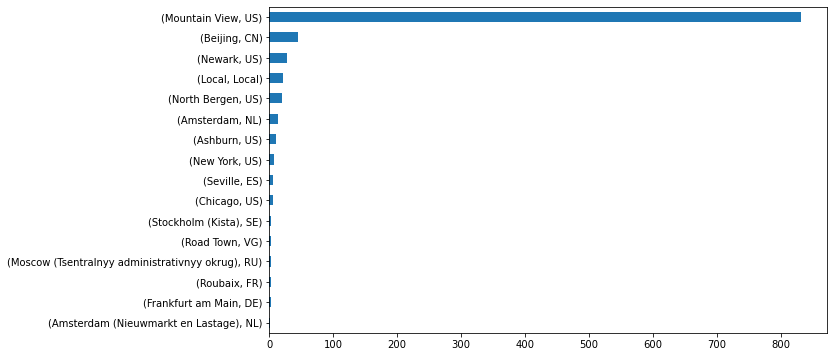

In [34]:

Logs_copy.Location.value_counts(ascending = True).plot(kind = 'barh', figsize = (10,6))

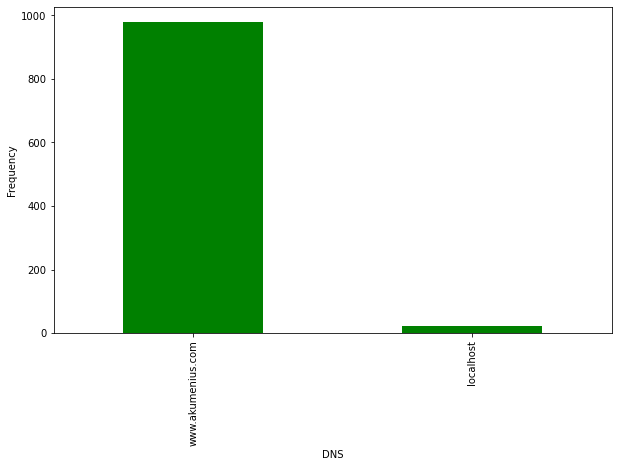

In [35]:
graph = Logs_copy[['DNS', 'Location']].groupby(['DNS']).count().sort_values(by = 'Location',ascending = False)
graph = graph.rename(columns = {'Location' : 'Frequency'})
graph.plot.bar(y = 'Frequency', color = 'g', ylabel = 'Frequency', legend = None, figsize = (10,6))
plt.show()

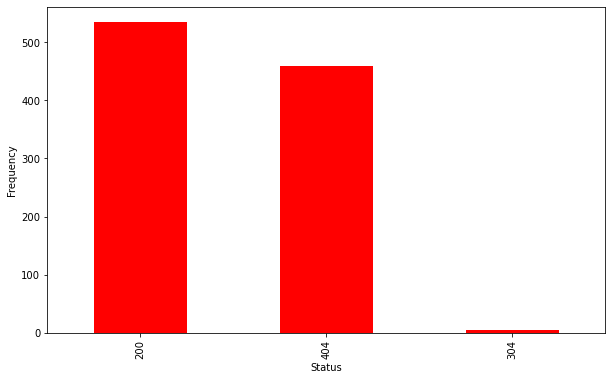

In [36]:
graph = Logs_copy[['Status', 'Date']].groupby(['Status']).count().sort_values(by = 'Date',ascending = False)
graph = graph.rename(columns = {'Date' : 'Frequency'})
graph.plot.bar(y = 'Frequency', color = 'r', ylabel = 'Frequency', legend = None, figsize = (10,6))
plt.show()

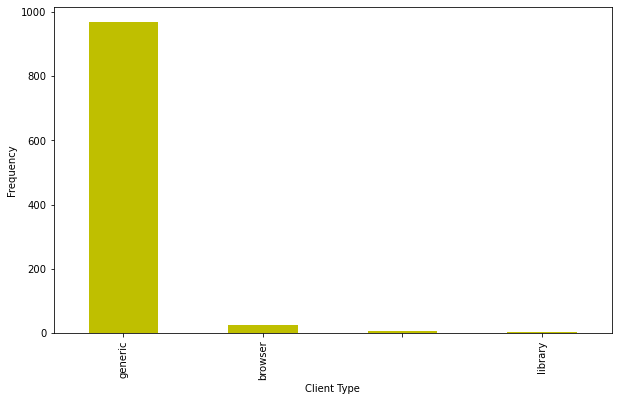

In [37]:
graph = Logs_copy[['Client Type', 'Date']].groupby(['Client Type']).count().sort_values(by = 'Date',ascending = False)
graph = graph.rename(columns = {'Date' : 'Frequency'})
graph.plot.bar(y = 'Frequency', color = 'y', ylabel = 'Frequency', legend = None, figsize = (10,6))
plt.show()

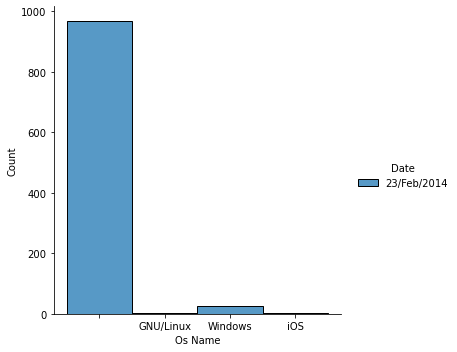

In [38]:
sns.displot(data = Logs_copy, x = "Os Name", hue = "Date", multiple = "stack")

In [39]:
Logs_export = Logs_copy.copy()

Logs_export.replace('', 'null', inplace = True)

Logs_export.to_csv('../Data/Logs_export.csv', index = False)